# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [12]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 195MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:23<00:00, 28.7MB/s]
mv: cannot move 'train_librispeech_10h' to 'lab3/data/train_librispeech_10h': Directory not empty
/content/lab3


In [13]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [14]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [15]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [16]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [17]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.4869


epoch 1:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.2474


epoch 2:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.2084


epoch 3:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1830


epoch 4:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1633


epoch 5:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1475


epoch 6:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1348


epoch 7:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1241


epoch 8:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1148


epoch 9:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.1066
Time is: 1 min 39 sec


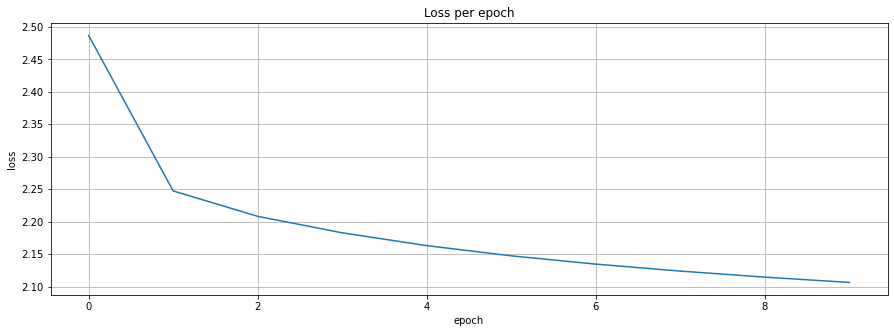

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [9]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128635 [00:00<?, ?it/s]

Total frame accuracy is 0.415

SIL: 0.96 : 21863/22832
SPN: 0.00 : 0/583
AA0: 0.00 : 0/39
AA1: 0.45 : 846/1887
AA2: 0.00 : 0/99
AE0: 0.00 : 0/64
AE1: 0.53 : 1919/3634
AE2: 0.00 : 0/101
AH0: 0.29 : 1695/5763
AH1: 0.25 : 471/1872
AH2: 0.00 : 0/41
AO0: 0.00 : 0/21
AO1: 0.26 : 502/1933
AO2: 0.00 : 0/78
AW0: 0.00 : 0/4
AW1: 0.02 : 23/1060
AW2: 0.00 : 0/41
AY0: 0.00 : 0/57
AY1: 0.13 : 389/2902
AY2: 0.00 : 0/190
B  : 0.08 : 131/1550
CH : 0.02 : 16/904
D  : 0.12 : 472/3976
DH : 0.03 : 68/2034
EH0: 0.00 : 0/62
EH1: 0.22 : 644/2886
EH2: 0.00 : 0/93
ER0: 0.23 : 593/2618
ER1: 0.05 : 48/906
ER2: 0.00 : 0/14
EY0: 0.00 : 0/40
EY1: 0.37 : 891/2396
EY2: 0.00 : 0/119
F  : 0.39 : 902/2311
G  : 0.00 : 3/812
HH : 0.21 : 450/2130
IH0: 0.03 : 74/2725
IH1: 0.15 : 354/2311
IH2: 0.00 : 0/95
IY0: 0.36 : 822/2305
IY1: 0.41 : 942/2324
IY2: 0.00 : 0/50
JH : 0.04 : 23/645
K  : 0.31 : 953/3055
L  : 0.59 : 2504/4253
M  : 0.23 : 709/3108
N  : 0.57 : 3452/6021
NG : 0.14 : 192/1350
OW0: 0.00 : 0/236
OW1: 0.16 : 315/1911


### Распознавание по словарю с помощью нейронной сети

In [18]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [19]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [20]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [21]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [14]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fe1916ba_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.66 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [15]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> SIX
result: one_fc2411fe_nohash_0       ==> NINE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
------------------------------------------------------------
WER is: 20.00%
Total time is: 14.73 sec


### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### **Ответ**:
...

In [22]:
def window(data, context=0):
    data = np.pad(data, pad_width=((context, context), (0, 0)), mode="edge")
    data_list = []
    for frame in range(context, len(data) - context):
        frames = list(range(frame - context, frame + context + 1))
        data_list.append(np.concatenate([data[x] for x in frames]))
    return np.asarray(data_list)

In [23]:
print(f"data_list shape {data_list.shape}" )

data_list shape (1286346, 14)


In [24]:
# объединение кадров признаков с соответствующими им фонемам:
def merge_data(ali_dict, feats_dict, phones_dict, context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        # window function
        file_feats = window(file_feats, context=context)
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list) / sum(priors_list)


context = 2
data_list, priors_list = merge_data(ali_dict, feats_dict, phones_dict, context)
data_list = np.random.permutation(data_list)
data_list.shape

(1286346, 66)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.2152


epoch 1:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.8621


epoch 2:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7783


epoch 3:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7250


epoch 4:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6859


epoch 5:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6556


epoch 6:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6312


epoch 7:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6111


epoch 8:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5942


epoch 9:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5794
Time is: 1 min 43 sec


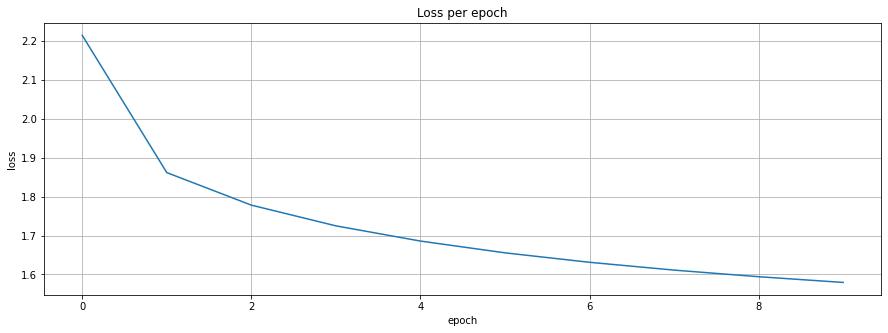

In [26]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [27]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128635 [00:00<?, ?it/s]

Total frame accuracy is 0.533

SIL: 0.96 : 21958/22901
SPN: 0.00 : 0/565
AA0: 0.00 : 0/54
AA1: 0.34 : 594/1738
AA2: 0.00 : 0/78
AE0: 0.00 : 0/52
AE1: 0.53 : 1917/3648
AE2: 0.00 : 0/110
AH0: 0.40 : 2262/5674
AH1: 0.24 : 457/1902
AH2: 0.00 : 0/47
AO0: 0.00 : 0/21
AO1: 0.42 : 840/1981
AO2: 0.00 : 0/57
AW0: 0.00 : 0/1
AW1: 0.29 : 320/1110
AW2: 0.03 : 1/38
AY0: 0.00 : 0/69
AY1: 0.56 : 1583/2836
AY2: 0.00 : 1/202
B  : 0.25 : 387/1557
CH : 0.32 : 288/888
D  : 0.32 : 1291/3978
DH : 0.35 : 708/2027
EH0: 0.00 : 0/45
EH1: 0.28 : 783/2840
EH2: 0.01 : 1/99
ER0: 0.42 : 1102/2634
ER1: 0.24 : 239/988
ER2: 0.00 : 0/16
EY0: 0.00 : 0/36
EY1: 0.54 : 1241/2301
EY2: 0.01 : 1/141
F  : 0.58 : 1323/2292
G  : 0.14 : 128/892
HH : 0.43 : 853/2001
IH0: 0.14 : 393/2774
IH1: 0.27 : 620/2335
IH2: 0.00 : 0/116
IY0: 0.39 : 910/2312
IY1: 0.58 : 1345/2307
IY2: 0.02 : 1/55
JH : 0.18 : 116/643
K  : 0.40 : 1277/3191
L  : 0.59 : 2542/4274
M  : 0.47 : 1424/3041
N  : 0.65 : 3974/6073
NG : 0.24 : 339/1390
OW0: 0.00 : 0/212
OW1:

In [33]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = {
    key: window(value, side_context=side_context)
    for key, value in records_data_dict.items()
}

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> SIX
result: one_fc2411fe_nohash_0       ==> NINE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: two_fb2f3242_nohash_0       ==> TWO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
------------------------------------------------------------
WER is: 10.00%
Total time is: 13.10 sec


In [30]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = {
    key: window(value, side_context=side_context)
    for key, value in records_data_dict.items()
}

In [31]:
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

result: yes_fe1916ba_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.61 sec
------------------------------------------------------------


In [ ]:
# The score has improved compared to previous method!

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Ответ**:
...

In [35]:
class Net(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = Net(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.9545


epoch 1:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7184


epoch 2:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6411


epoch 3:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5921


epoch 4:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5560


epoch 5:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5270


epoch 6:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5031


epoch 7:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.4822


epoch 8:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.4639


epoch 9:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.4476
Time is: 2 min 14 sec


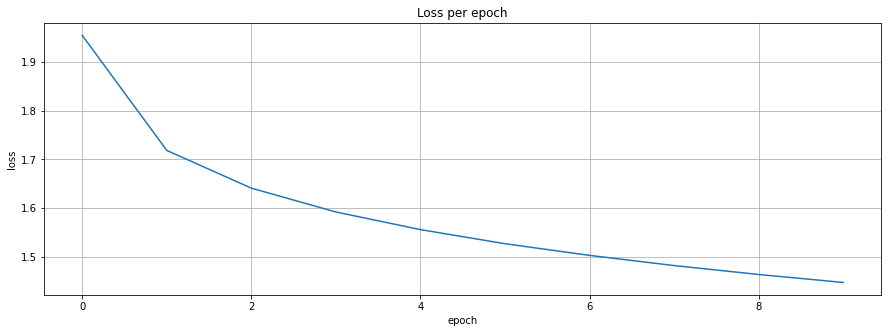

In [37]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [38]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128635 [00:00<?, ?it/s]

Total frame accuracy is 0.555

SIL: 0.95 : 21858/22901
SPN: 0.01 : 6/565
AA0: 0.00 : 0/54
AA1: 0.32 : 551/1738
AA2: 0.03 : 2/78
AE0: 0.00 : 0/52
AE1: 0.55 : 2023/3648
AE2: 0.00 : 0/110
AH0: 0.41 : 2306/5674
AH1: 0.29 : 553/1902
AH2: 0.00 : 0/47
AO0: 0.00 : 0/21
AO1: 0.42 : 823/1981
AO2: 0.00 : 0/57
AW0: 0.00 : 0/1
AW1: 0.30 : 338/1110
AW2: 0.03 : 1/38
AY0: 0.00 : 0/69
AY1: 0.61 : 1726/2836
AY2: 0.00 : 1/202
B  : 0.33 : 512/1557
CH : 0.32 : 285/888
D  : 0.36 : 1437/3978
DH : 0.42 : 860/2027
EH0: 0.00 : 0/45
EH1: 0.27 : 773/2840
EH2: 0.00 : 0/99
ER0: 0.45 : 1187/2634
ER1: 0.36 : 360/988
ER2: 0.00 : 0/16
EY0: 0.00 : 0/36
EY1: 0.54 : 1239/2301
EY2: 0.00 : 0/141
F  : 0.64 : 1456/2292
G  : 0.17 : 155/892
HH : 0.47 : 932/2001
IH0: 0.20 : 543/2774
IH1: 0.28 : 658/2335
IH2: 0.00 : 0/116
IY0: 0.44 : 1015/2312
IY1: 0.61 : 1410/2307
IY2: 0.00 : 0/55
JH : 0.25 : 162/643
K  : 0.48 : 1522/3191
L  : 0.63 : 2672/4274
M  : 0.47 : 1421/3041
N  : 0.66 : 4021/6073
NG : 0.28 : 385/1390
OW0: 0.01 : 2/212
OW1

In [39]:
records_data_dict = load_data_dict("data/digits/records")
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = {
    key: window(value, side_context=side_context)
    for key, value in records_data_dict.items()
}
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: one_fc2411fe_nohash_0       ==> NINE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: two_fb2f3242_nohash_0       ==> TWO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
------------------------------------------------------------
WER is: 5.00%
Total time is: 20.36 sec

In [40]:
records_data_dict = load_data_dict("data/yes_no/records")
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = {
    key: window(value, side_context=side_context)
    for key, value in records_data_dict.items()
}
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fe1916ba_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 1.83 sec
------------------------------------------------------------


In [53]:
class Net(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = Net(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(20):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.4959


epoch 1:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.0475


epoch 2:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.9542


epoch 3:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.9012


epoch 4:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.8656


epoch 5:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.8380


epoch 6:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.8168


epoch 7:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.8002


epoch 8:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7856


epoch 9:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7746


epoch 10:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7618


epoch 11:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7526


epoch 12:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7428


epoch 13:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7351


epoch 14:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7273


epoch 15:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7212


epoch 16:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7151


epoch 17:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7091


epoch 18:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7031


epoch 19:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6973
Time is: 3 min 41 sec


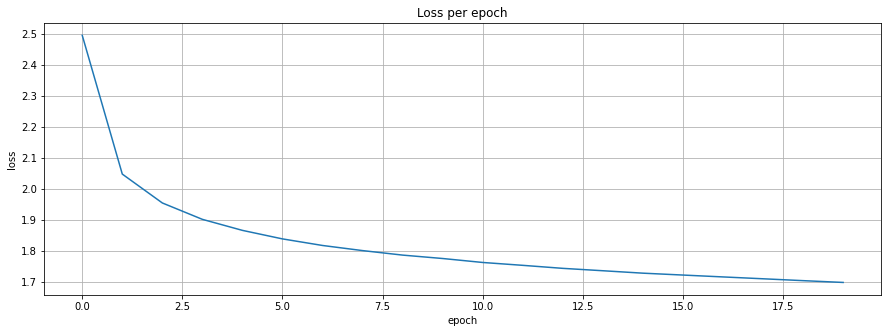

In [56]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [57]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128635 [00:00<?, ?it/s]

Total frame accuracy is 0.499

SIL: 0.95 : 21707/22901
SPN: 0.00 : 0/565
AA0: 0.00 : 0/54
AA1: 0.32 : 557/1738
AA2: 0.00 : 0/78
AE0: 0.00 : 0/52
AE1: 0.51 : 1865/3648
AE2: 0.00 : 0/110
AH0: 0.36 : 2015/5674
AH1: 0.19 : 359/1902
AH2: 0.00 : 0/47
AO0: 0.00 : 0/21
AO1: 0.38 : 744/1981
AO2: 0.00 : 0/57
AW0: 0.00 : 0/1
AW1: 0.23 : 257/1110
AW2: 0.00 : 0/38
AY0: 0.00 : 0/69
AY1: 0.51 : 1460/2836
AY2: 0.00 : 0/202
B  : 0.25 : 392/1557
CH : 0.16 : 146/888
D  : 0.29 : 1135/3978
DH : 0.27 : 539/2027
EH0: 0.00 : 0/45
EH1: 0.27 : 774/2840
EH2: 0.00 : 0/99
ER0: 0.39 : 1018/2634
ER1: 0.13 : 126/988
ER2: 0.00 : 0/16
EY0: 0.00 : 0/36
EY1: 0.48 : 1111/2301
EY2: 0.00 : 0/141
F  : 0.53 : 1206/2292
G  : 0.09 : 84/892
HH : 0.33 : 663/2001
IH0: 0.10 : 281/2774
IH1: 0.19 : 455/2335
IH2: 0.00 : 0/116
IY0: 0.34 : 792/2312
IY1: 0.58 : 1336/2307
IY2: 0.00 : 0/55
JH : 0.13 : 86/643
K  : 0.45 : 1447/3191
L  : 0.57 : 2444/4274
M  : 0.42 : 1271/3041
N  : 0.58 : 3544/6073
NG : 0.24 : 337/1390
OW0: 0.00 : 0/212
OW1: 0

In [58]:
records_data_dict = load_data_dict("data/digits/records")
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = {
    key: window(value, side_context=side_context)
    for key, value in records_data_dict.items()
}
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: one_fc2411fe_nohash_0       ==> ONE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: two_fb2f3242_nohash_0       ==> TWO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
------------------------------------------------------------
WER is: 0.00%
Total time is: 22.70 sec


In [59]:
records_data_dict = load_data_dict("data/yes_no/records")
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = {
    key: window(value, side_context=side_context)
    for key, value in records_data_dict.items()
}
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fe1916ba_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 1.03 sec
------------------------------------------------------------


In [ ]:
# The deeper network has improved the score numbers from 10% to 5%
# The lower learning rate and more epoch, but it did not help
# try include dropout into network, but still did not improve the score